# Data Analysis on San Francisco Bikeshare Data

## Introduction
This notebook explores a public dataset containing information on San Francisco bikeshare trip data, providing insights into usage patterns and demographics.

## Data Preparation
### Constructing the Dataset and Loading the Data

In this section, we will generate three distinct tables in BigQuery to comprehensively capture the details of the bikeshare trips, weather data, and a unified dataset that includes periods with no recorded trips. This multi-step approach ensures that we have all necessary information for thorough analysis and operational decision-making.

1. **Trip Details Table**: 
   - Captures the details of all recorded trips for every station.
   - Includes summary statistics per station per day such as trip count, average trip duration, and trip distance.

2. **Weather Details Table**: 
   - Stores weather details from the closest possible weather station for each bike station.
   - Captures key metrics such as average temperature, average windspeed, and total precipitation per day per station.

3. **Comprehensive Daily Station Data Table**: 
   - Joins trip details with weather data to create a comprehensive narrative for each station per day.
   - Adds entries for days when no trips were recorded to ensure that 0 values for trip count are present when no activity occurred.

This structured approach will provide a robust dataset for further analysis and visualization.

### SQL Queries for Dataset Construction

#### 1. Trip Details Table
The first SQL query constructs a table that aggregates trip data per station per day, including essential trip statistics.

#### 2. Weather Details Table
The second SQL query collects weather data from nearby weather stations for each bike station, summarizing daily weather conditions.

#### 3. Comprehensive Daily Station Data Table
The final SQL query joins the trip details and weather data tables, ensuring all days (including those with no trips) are represented for each station.

Let's begin by executing the SQL queries to create these tables in BigQuery.

## Bike Trips Table
The SQL query below creates a table in BigQuery named `bikeshare_trip_data`. The query joins station data with region data to add region names to each station and then processes trip data to adjust data types, compute trip distances, and aggregate trip metrics by day and station.

#### SQL Query Explanation
- **Join Region Data with Station Data**:
  - This part of the query joins the `bikeshare_station_info` table with the `bikeshare_regions` table to add region names to each station.
  - The result is stored in the Common Table Expression (CTE) `station_data`.

- **Adjust Trip Data Types and Compute Metrics**:
  - This part of the query processes the `bikeshare_trips` table.
  - Adjusts date and time fields for easier processing and computes the day of the week and trip distance.
  - The result is stored in the CTE `bike_trips`.

- **Join Station and Trip Data**:
  - Joins the `station_data` with `bike_trips` to augment each trip with station and region information.
  - Aggregates trip metrics (e.g., trip count, average trip time, and distance) by day and station.
  - Filters out records with null region IDs and groups the data by various dimensions (e.g., date, station, region).

### SQL Query Code


```sql
CREATE OR REPLACE TABLE `portfolio-project-429216.bikeshare_project.bikeshare_trip_data`
CLUSTER BY start_year AS

WITH
-- Join Region data with Station data to add region name as a field into the station_data CTE
  station_data AS (
  SELECT
    st.station_id,
    st.name AS station_name, 
    st.short_name,
    st.region_id,
    rg.name AS region_name,
    st.capacity AS station_capacity,
    st.has_kiosk
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS st
  LEFT JOIN
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` AS rg
  ON
    rg.region_id = st.region_id
  ),
-- Adjust Trip datatypes where required, adjusting id fields to strings and mutating date fields where required for easier processing
  bike_trips AS (
  SELECT
    trip_id,
    duration_sec,
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM DATETIME(start_date, 'America/Los_Angeles')) = 1 THEN 7
      ELSE EXTRACT(DAYOFWEEK FROM DATETIME(start_date, 'America/Los_Angeles')) - 1
    END AS day_of_week,
    DATE(start_date, 'America/Los_Angeles') AS start_date, -- start_date initially stored as UTC timestamp
    DATE(DATE_TRUNC(start_date, YEAR)) AS start_year, -- adding a year field for data clustering to optimize storage
    CAST(start_station_id AS STRING) AS start_station_id, -- convert station_id to string for preferred data type
    DATETIME(end_date, 'America/Los_Angeles') AS end_date,
    CAST(end_station_id AS STRING) AS end_station_id,
    DATE(DATETIME(MIN(start_date) OVER (PARTITION BY CAST(start_station_id AS STRING)), 'America/Los_Angeles')) AS first_trip, -- identify earliest recorded trip date per station, which we will utilize later once all tables are joined
    DATE(DATETIME(MAX(start_date) OVER (PARTITION BY CAST(start_station_id AS STRING)), 'America/Los_Angeles')) AS last_trip, -- identify latest recorded trip date per station, which we will utilize later once all tables are joined
    bike_number,
    subscriber_type,
    member_birth_year,
    member_gender,
    bike_share_for_all_trip,
    start_station_longitude,
    start_station_latitude,
    start_station_geom,
    end_station_geom,
    ST_DISTANCE(start_station_geom, end_station_geom) AS trip_distance -- calculate trip distance in meters per trip
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS bt
  )
-- Join Station and Trip data to augment information regarding each trip and aggregate trip metrics per day
SELECT
  st.region_id AS start_region_id,
  st.region_name AS start_region_name,
  bt.start_station_id,
  bt.start_station_longitude,
  bt.start_station_latitude,
  st.station_capacity AS start_station_capacity,
  bt.start_year,
  bt.start_date,
  bt.day_of_week,
  bt.first_trip,
  bt.last_trip,
  COUNT(bt.trip_id) AS trip_count,
  AVG(bt.duration_sec) AS avg_trip_time,
  AVG(bt.trip_distance) AS avg_trip_distance
FROM
  bike_trips AS bt
LEFT JOIN
  station_data AS st
ON
  bt.start_station_id = st.station_id
WHERE
  st.region_id IS NOT NULL
GROUP BY
  bt.start_year,
  bt.start_date,
  bt.day_of_week,
  bt.start_station_id,
  bt.start_station_longitude,
  bt.start_station_latitude,
  st.region_id,
  st.region_name,
  st.station_capacity,
  bt.first_trip,
  bt.last_trip


## Weather Details Table

This SQL query constructs a table that captures weather details from the closest possible weather stations for each bike station. The query performs several key steps to ensure accurate and comprehensive weather data integration:

1. **Join Region Data with Station Data**:
   - Collects weather station data from NOAA's Global Surface Summary of the Day (GSOD) dataset.
   - Filters for weather stations in California, ensuring relevant geographical coverage.

2. **Calculate Distances**:
   - Measures the distance between each bike station and all regional weather stations.
   - Determines the closest weather station for each bike station to provide the most accurate weather data.

3. **Filter Closest Weather Stations**:
   - Uses a ranking system to identify and filter out the closest weather station for each bike station.

4. **Daily Weather Reports**:
   - Consolidates weather data from multiple years (2013-2018) to provide a comprehensive view of weather conditions.
   - Recasts default values as NULLs or appropriate placeholders to handle missing data effectively.

5. **Join and Filter Weather Reports**:
   - Joins daily weather reports with the pre-filtered list of the closest weather stations for each bike station.
   - Applies a DISTINCT statement to remove duplicate records and ensure data integrity.

6. **Final Selection**:
   - Consolidates longitude and latitude into a single geographical point for each bike station.
   - Provides a detailed view of weather conditions for each bike station, including metrics such as maximum temperature, average temperature, windspeed, and total precipitation.

This table will inform us of key weather metrics per day per station, which will later be joined with the trip details table to create a comprehensive dataset for further analysis and operational decision-making.

### SQL Query Code

```sql

CREATE OR REPLACE TABLE `portfolio-project-429216.bikeshare_project.bike_region_weather`
CLUSTER BY year AS

WITH
  -- Select regional stations in California
  region_stations AS (
  SELECT
    usaf,
    name,
    lon AS longitude,
    lat AS latitude,
    ST_GEOGPOINT(lon, lat) AS station_geo
  FROM
    `bigquery-public-data.noaa_gsod.stations`
  WHERE
    country = 'US'
    AND state = 'CA'
  ),
  -- Calculate the distance between each bike station and all regional weather stations
  distances AS (
  SELECT
    b.start_station_id,
    b.start_region_id,
    b.start_region_name,
    n.usaf,
    ST_DISTANCE(b.station_geo, n.station_geo) AS distance -- Measure distance between bike station and all regional stations
  FROM (
    SELECT
      t.start_station_id,
      t.start_region_id,
      t.start_region_name,
      ST_GEOGPOINT(t.start_station_longitude, t.start_station_latitude) AS station_geo
    FROM
      `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` AS t
  ) b
  CROSS JOIN
    region_stations n
  WHERE
    n.usaf <> '999999' -- Exclude null station codes as per documentation
  ),
  -- Filter to select the closest NOAA station for each bike station
  noaa_station_filter AS (
  SELECT
    start_station_id,
    start_region_id,
    start_region_name,
    usaf,
    distance
  FROM (
    SELECT
      start_station_id,
      start_region_id,
      start_region_name,
      usaf,
      distance,
      ROW_NUMBER() OVER (PARTITION BY start_station_id ORDER BY distance) AS rank -- Rank distances to filter for best fit
    FROM
      distances
  )
  WHERE
    rank = 1 -- Select the closest weather station
  ),
  -- Filter bike stations and remove duplicates
  bike_station_filter AS (
  SELECT
    n.start_station_id AS bike_station_id,
    n.start_region_id AS region_id,
    n.start_region_name AS region_name,
    n.distance,
    s.*
  FROM
    noaa_station_filter AS n
  LEFT JOIN
    region_stations AS s
  ON
    n.usaf = s.usaf
  WHERE
    distance IS NOT NULL
    AND s.name NOT LIKE '%OAKLAND/METROP. OAK%' -- Exclude specific problematic station
  ),
  -- Aggregate daily weather reports from 2013-2018, converting default values to NULLs
  daily_reports AS (
  SELECT
    DISTINCT stn AS station_id,
    CAST(CONCAT(year, '-', mo, '-', da) AS DATE) AS date,
    IF(CAST(wdsp AS FLOAT64) = 999.9, NULL, CAST(wdsp AS FLOAT64)) AS windspeed,
    IF(TEMP = 9999.9, NULL, TEMP) AS avg_temp,
    IF(max = 9999.9, NULL, max) AS max_temp,
    IF(prcp = 99.99, 0.0, prcp) AS total_precipitation
  FROM (
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2013`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2014`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2015`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2016`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2017`
    UNION ALL
    SELECT * FROM bigquery-public-data.noaa_gsod.gsod2018
  )
  ),
  -- Join the daily weather reports with the filtered station data
  station_reports AS (
  SELECT
    DISTINCT rs.region_name,
    rs.region_id,
    rs.usaf,
    rs.bike_station_id,
    rs.longitude,
    rs.latitude,
    dr.date,
    DATE_TRUNC(dr.date, YEAR) AS year,
    dr.max_temp,
    dr.avg_temp,
    dr.windspeed,
    dr.total_precipitation
  FROM
    bike_station_filter AS rs
  LEFT JOIN
    daily_reports AS dr
  ON
    dr.station_id = rs.usaf
  WHERE
    dr.date IS NOT NULL
  )
-- Final SELECT statement to create the consolidated table
SELECT
  region_name,
  region_id,
  usaf,
  bike_station_id,
  ST_GEOGPOINT(longitude, latitude) AS station_geo,
  date,
  year,
  max_temp,
  avg_temp,
  windspeed,
  total_precipitation
FROM
  station_reports


## Constructing the Final Dataset

### Introduction

This section describes the process of creating a comprehensive dataset that combines bikeshare trip data, weather data, and additional calculated features. The goal is to generate a complete dataset that covers all possible dates for each station, including days with no trips, and to provide meaningful metrics that can be used for further analysis and modeling.

### Steps

1. **Generate Date Array**:
   - Create a table of all dates within the range from `2013-01-01` to `2018-12-31`.
   - Extract the day of the week, month, quarter, and year from each date.

2. **Create All Possible Dates for Each Station**:
   - Generate a table of all possible dates for each station, including days with no trips.
   - Calculate the operational day since the first recorded trip for each station.
   - Initialize trip count to 0 for all dates.

3. **Aggregate and Calculate Metrics**:
   - Merge the generated dates with the trip data to fill in days with actual trip counts where available.
   - Calculate various metrics, including:
     - Average daily trips per month.
     - Average trips for each day of the week per month.
     - Previous week's trip count.
     - Rolling 14-day average trip count.
     - Weather-related metrics such as average temperature, maximum temperature, total precipitation, and windspeed.
     - Cumulative distribution metrics for weather variables to capture relative conditions within each region.

### SQL Query Code


```sql
CREATE OR REPLACE TABLE portfolio-project-429216.bikeshare_project.bikeshare_data_complete 
CLUSTER BY year AS

WITH
  -- Create a table of all dates within the given range (2013-01-01 to 2018-12-31)
  empty_dates AS (
  SELECT
    DISTINCT day,
    -- Extract the day of the week starting from Monday (1) to Sunday (7)
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM day) = 1 THEN 7
      ELSE EXTRACT(DAYOFWEEK FROM day) - 1
    END AS day_of_week,
    -- Extract the month from the date
    EXTRACT(MONTH FROM day) AS month,
    -- Extract the quarter from the date
    EXTRACT(QUARTER FROM day) AS quarter,
    -- Extract the year from the date and truncate to the start of the year
    DATE_TRUNC(day, YEAR) AS year
  FROM
    -- Generate a date array from 2013-01-01 to 2018-12-31
    UNNEST(GENERATE_DATE_ARRAY('2013-01-01', '2018-12-31')) AS day
  ORDER BY
    day
  ),
  -- Create a table of all possible dates for each station, including days with no trips
  all_dates AS (
  SELECT
    DISTINCT t.start_region_id,
    t.start_station_id,
    d.year,
    d.month,
    d.quarter,
    d.day AS date,
    -- Calculate the operational day since the first trip
    DATE_DIFF(d.day, DATE_SUB(t.first_trip, INTERVAL 1 DAY), DAY) AS operation_day,
    d.day_of_week,
    -- Initialize trip count to 0 for all dates
    0 AS trip_count
  FROM
    `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` t,
    empty_dates d
  WHERE
    d.day >= t.first_trip
    AND d.day <= t.last_trip
  )
-- Select and aggregate data to create the final dataset
SELECT
  a.start_region_id,
  a.start_station_id,
  a.year,
  a.month,
  -- Calculate the average daily trips for each station per month
  AVG(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id, a.year, a.month) AS avg_month_daily_trips,
  a.quarter,
  a.date,
  a.operation_day,
  a.day_of_week,
  -- Use actual trip count if available, otherwise use 0 (from all_dates)
  IFNULL(t.trip_count, a.trip_count) AS trip_count,
  t.avg_trip_distance,
  t.avg_trip_time,
  -- Calculate the average trips for each station for each day of the week per month
  AVG(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id, a.month, a.day_of_week) AS avg_dow_trips,
  -- Calculate the previous week's trip count for each station
  LAG(IFNULL(t.trip_count, a.trip_count), 7) OVER (PARTITION BY a.start_station_id ORDER BY a.date) AS prev_dow_trip_count,
  -- Calculate the rolling 14-day average trip count for each station
  SUM(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id ORDER BY a.date ASC ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) / 
  COUNT(a.date) OVER (PARTITION BY a.start_station_id ORDER BY a.date ASC ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) AS rolling_14_day_avg,
  w.avg_temp,
  -- Calculate the cumulative distribution for average temperature within each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.avg_temp) AS avg_temp_dist,
  w.max_temp,
  -- Calculate the cumulative distribution for maximum temperature within each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.max_temp) AS max_temp_dist,
  w.total_precipitation,
  -- Calculate the cumulative distribution for total precipitation within each region in descending order
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.total_precipitation DESC) AS precipitation_dist,
  w.windspeed,
  -- Calculate the cumulative distribution for windspeed within each region in descending order
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.windspeed DESC) AS windspeed_dist,
  -- Calculate the interaction of weather conditions for each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.avg_temp) * 
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.total_precipitation DESC) *
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.windspeed DESC) AS weather_interaction_dist
FROM
  all_dates AS a
FULL JOIN
  `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` AS t
ON
  t.start_station_id = a.start_station_id
  AND t.start_date = a.date
LEFT JOIN
  `portfolio-project-429216.bikeshare_project.bike_region_weather` AS w
ON
  w.bike_station_id = a.start_station_id
  AND w.date = a.date


## Data Cleaning

In this section, we perform data cleaning to prepare the bikeshare dataset for analysis. This involves handling missing values, removing outliers, and correcting any inconsistencies in the data. By ensuring the dataset is clean and properly formatted, we can improve the accuracy and reliability of our subsequent analysis and modeling efforts.

### Load all relevant modules for loading, cleaning and analyzing the data

In [1]:
# Import libraries and modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Load the CSV file that was generated from BigQuery and generate summary statistics for the dataset

In [2]:
# Load the data
df = pd.read_csv(r'C:\Users\iauge\Portfolio Projects\bikeshare_trip_data.csv')

# Review columns and data types

print(df.dtypes)
print(df.describe())

start_region_id               int64
start_station_id              int64
year                         object
month                         int64
avg_month_daily_trips       float64
quarter                       int64
date                         object
operation_day                 int64
day_of_week                   int64
trip_count                    int64
avg_trip_distance           float64
avg_trip_time               float64
avg_dow_trips               float64
prev_dow_trip_count         float64
rolling_14_day_avg          float64
avg_temp                    float64
avg_temp_dist               float64
max_temp                    float64
max_temp_dist               float64
total_precipitation         float64
precipitation_dist          float64
windspeed                   float64
windspeed_dist              float64
weather_interaction_dist    float64
dtype: object
       start_region_id  start_station_id          month  \
count    151984.000000     151984.000000  151984.000000   
mean

### Selecting Numerical Columns for Correlation Analysis

In this section, we filter the dataset to retain only the numerical columns. This allows us to perform a correlation analysis to understand the relationships between the various numerical features, particularly focusing on how they correlate with the target variable, `trip_count`.

#### Generating a Correlation Heatmap

Here, we calculate the correlation matrix for all numerical features and visualize the correlations using a heatmap. This heatmap helps identify strong positive or negative relationships between the features.

#### Extracting and Visualizing Correlation with Target Variable

In this step, we focus on the correlation of each feature with `trip_count`, the target variable. We sort these correlations and generate a heatmap to easily identify which features are most strongly correlated with `trip_count`.

#### Identifying and Displaying Highly Correlated Feature Pairs

Finally, we identify pairs of features that are highly correlated with each other (correlation coefficient > 0.7 or < -0.7). We remove duplicate pairs and sort them alphabetically for clarity, then display these highly correlated pairs to understand potential multicollinearity in the dataset.


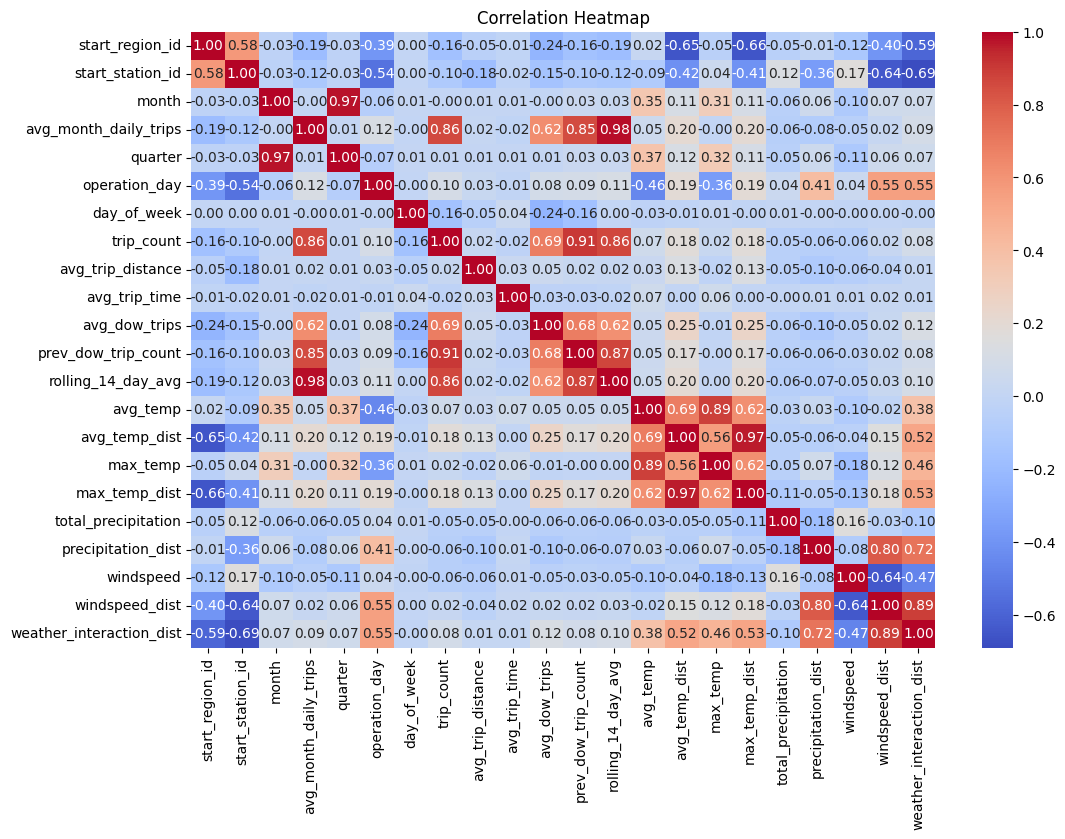

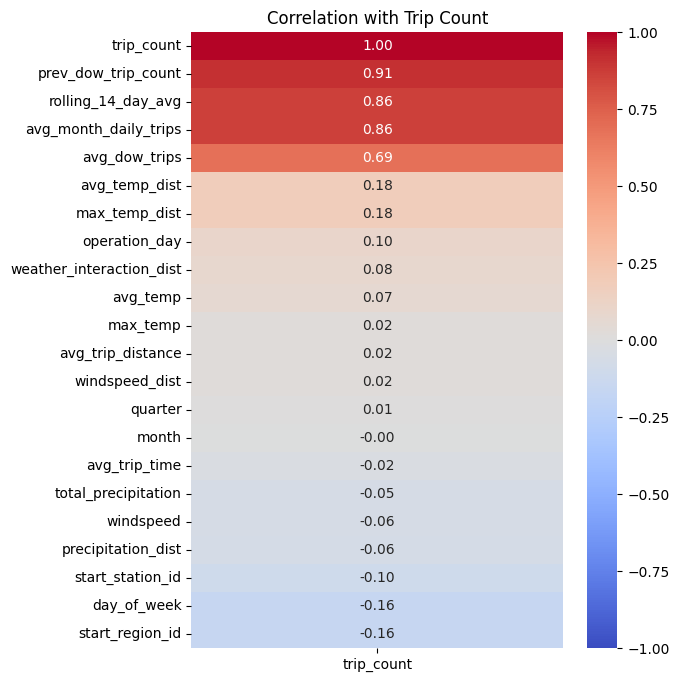

Highly correlated pairs (correlation > 0.7 or < -0.7):
avg_month_daily_trips and prev_dow_trip_count: 0.85
avg_month_daily_trips and rolling_14_day_avg: 0.98
avg_month_daily_trips and trip_count: 0.86
avg_temp and max_temp: 0.89
avg_temp_dist and max_temp_dist: 0.97
month and quarter: 0.97
precipitation_dist and weather_interaction_dist: 0.72
precipitation_dist and windspeed_dist: 0.80
prev_dow_trip_count and rolling_14_day_avg: 0.87
prev_dow_trip_count and trip_count: 0.91
rolling_14_day_avg and trip_count: 0.86
weather_interaction_dist and windspeed_dist: 0.89


In [3]:
# Selecting only numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation analysis
correlation_matrix = numerical_df.corr()

# Plotting the full correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Extracting the correlation with 'trip_count'
trip_count_corr = correlation_matrix[['trip_count']].sort_values(by='trip_count', ascending=False)

# Plotting the correlation heatmap for 'trip_count'
plt.figure(figsize=(6, 8))
sns.heatmap(trip_count_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Trip Count')
plt.show()

# Identifying highly correlated pairs
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns if i != j and abs(correlation_matrix.loc[i, j]) > 0.7]

# Remove duplicate pairs (e.g., if (a, b) and (b, a) both exist, keep only one)
unique_pairs = set(tuple(sorted(pair)) for pair in high_corr_pairs)

# Sort unique pairs alphabetically
sorted_pairs = sorted(unique_pairs)

# Printing the results
print("Highly correlated pairs (correlation > 0.7 or < -0.7):")
for pair in sorted_pairs:
    print(f"{pair[0]} and {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]:.2f}")



### Removing Highly Correlated Variables to Avoid Multicollinearity

In this step, we eliminate highly correlated features to reduce multicollinearity, while preserving the feature with the strongest correlation to the target variable, `trip_count`. We also remove variables with low correlation to the target, as well as unnecessary categorical variables such as `year`.


In [4]:
# Drop columns and reset dataframe

df = df.drop(columns=['avg_dow_trips','avg_month_daily_trips','rolling_14_day_avg','year', 'quarter', 'avg_trip_distance', 'avg_trip_time', 'avg_temp', 'max_temp', 'max_temp_dist', 'total_precipitation', 'windspeed', 'windspeed_dist', 'weather_interaction_dist'])

# Review structure of updated dataframe

df.dtypes

start_region_id          int64
start_station_id         int64
month                    int64
date                    object
operation_day            int64
day_of_week              int64
trip_count               int64
prev_dow_trip_count    float64
avg_temp_dist          float64
precipitation_dist     float64
dtype: object

### Handling NaN Values and Verifying Data Cleanliness

In this section, we handle any missing (`NaN`) values in the dataset by dropping rows with NaN values in critical columns. After cleaning the data, we verify that no NaN values remain. Finally, we use a pair plot to visualize the relationships between the remaining features and ensure the data is ready for further analysis.


start_region_id        0
start_station_id       0
month                  0
date                   0
operation_day          0
day_of_week            0
trip_count             0
prev_dow_trip_count    0
avg_temp_dist          0
precipitation_dist     0
dtype: int64


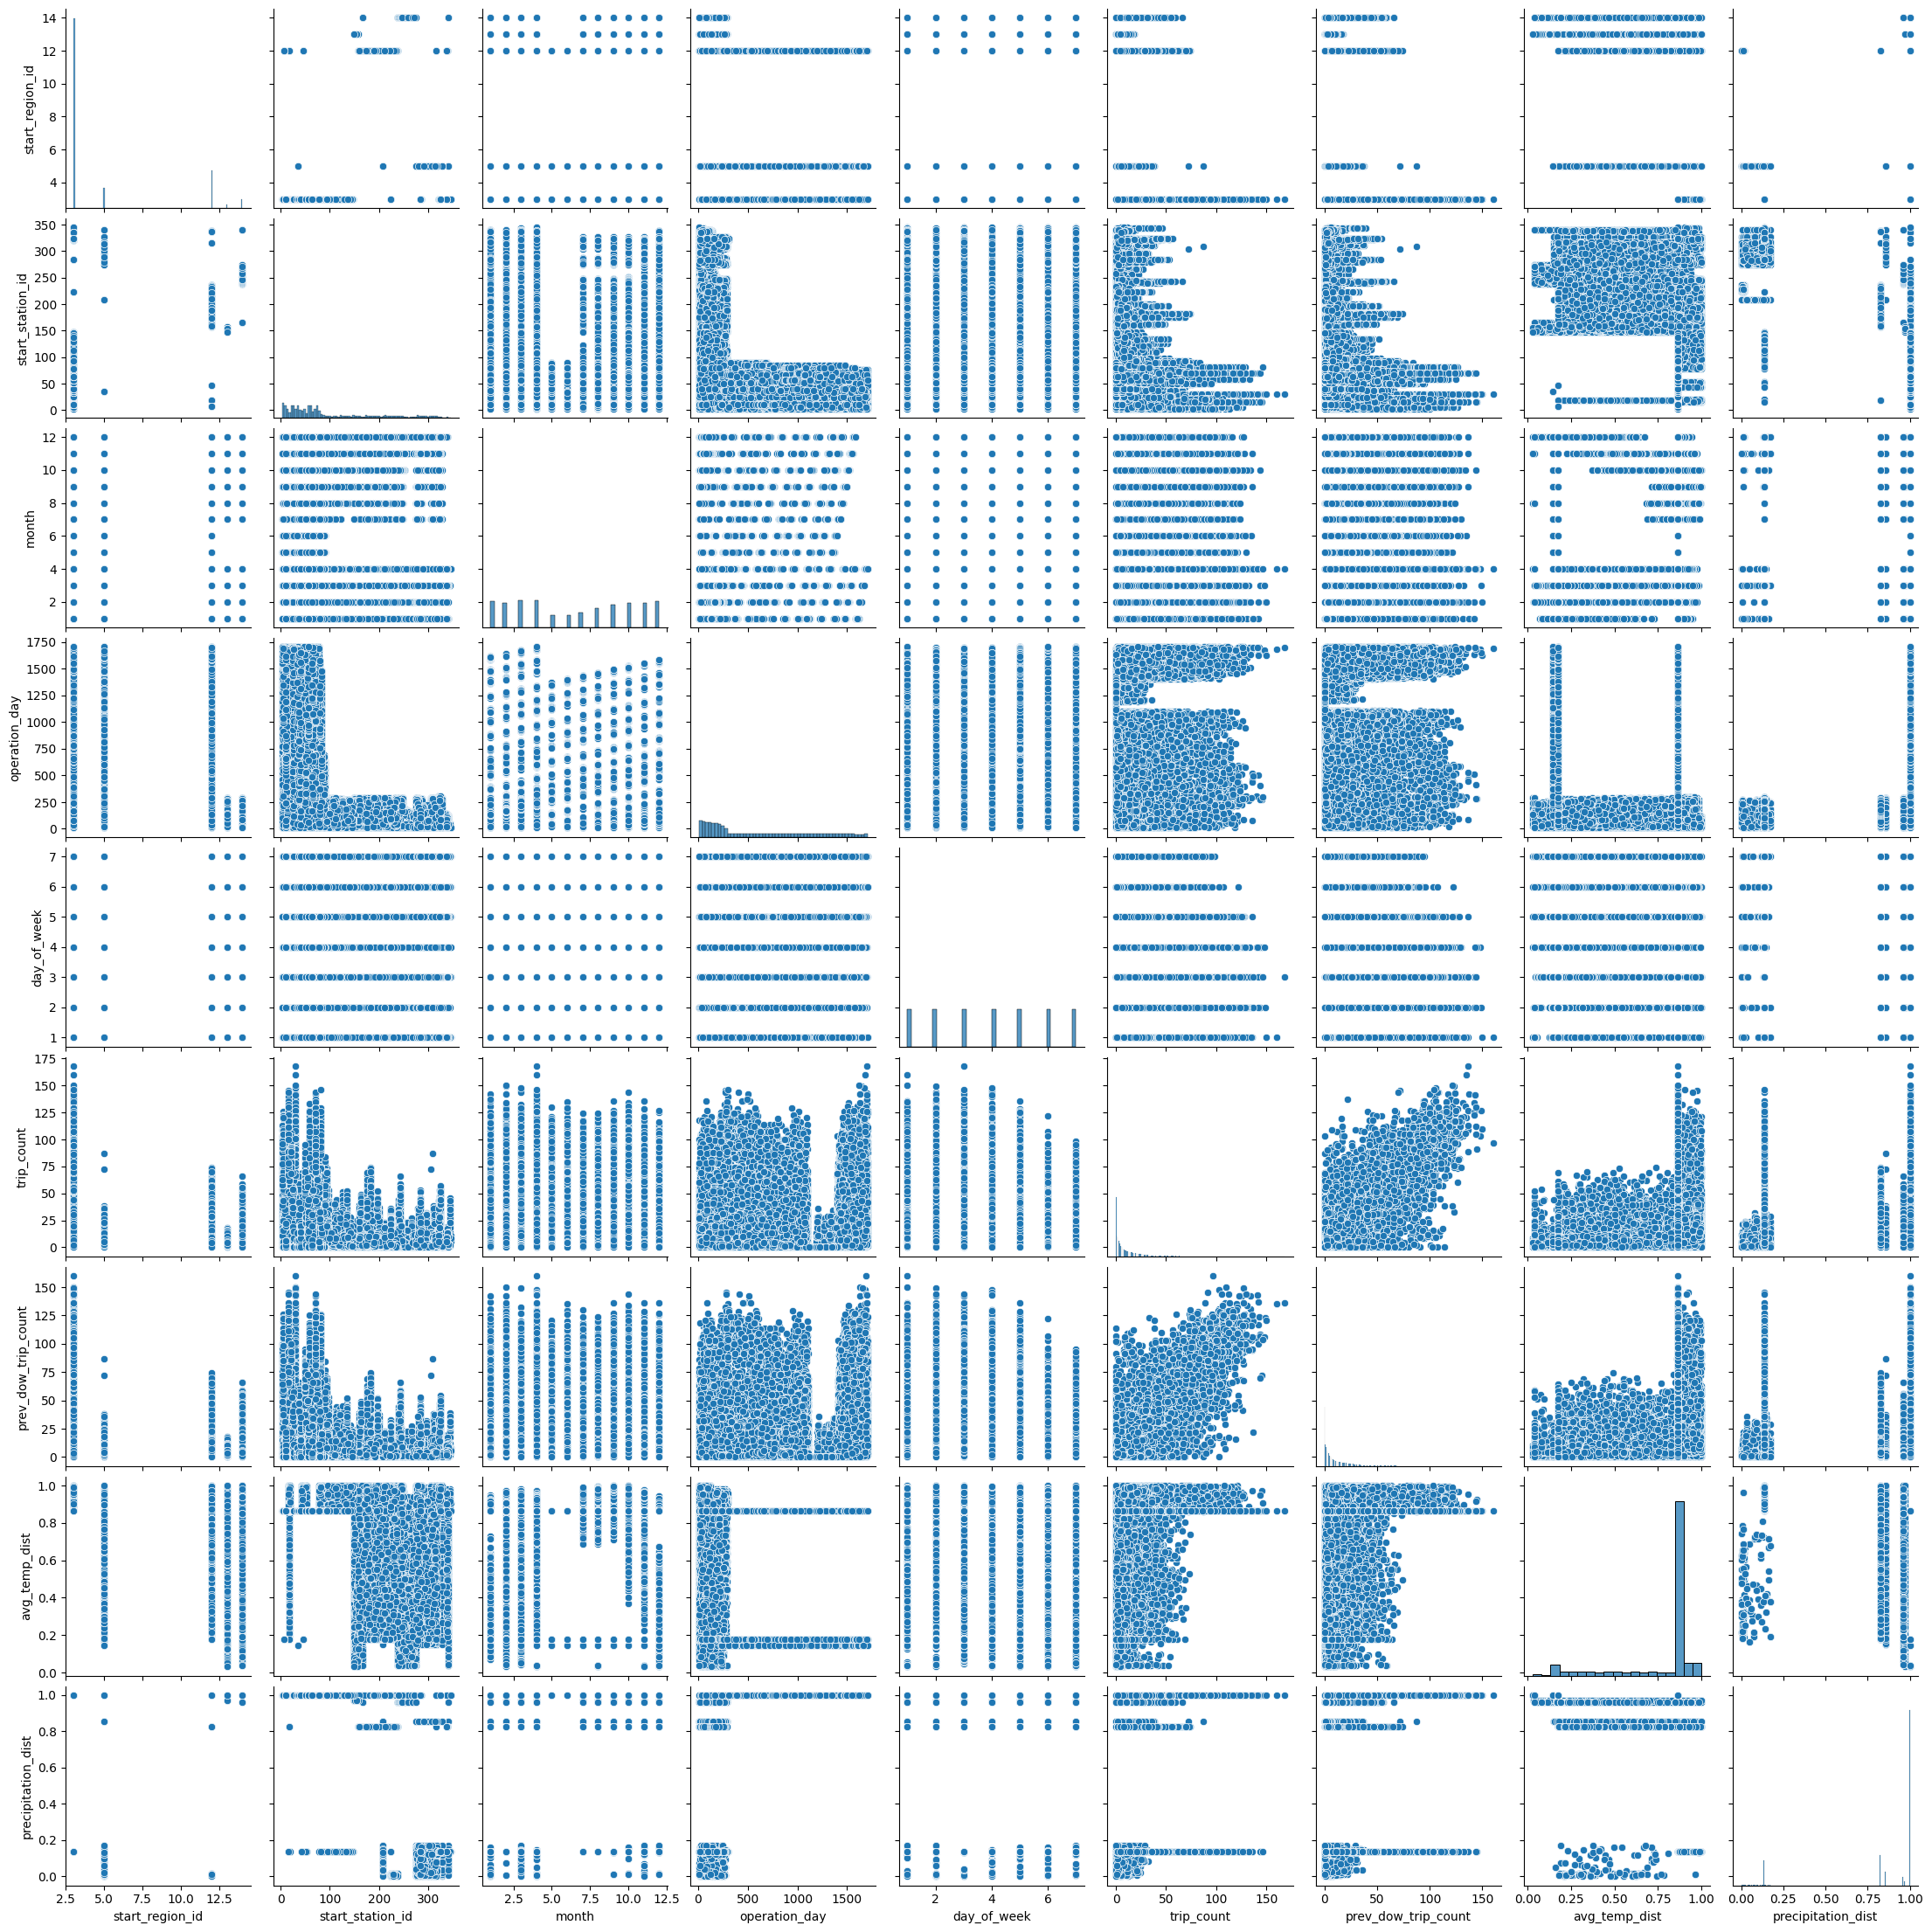

In [5]:
# Handle NaN values in the remaining critical columns
df.dropna(inplace=True)

# After dropping NaN values, verify if the data is clean
print(df.isna().sum())  # Check for any remaining NaN values

sns.pairplot(df)

### Pairplot Observations

While a clear linear relationship is observed between the target variable trip_count and the lagged trip count feature prev_dow_trip_count, other features do not exhibit strong linear relationships with the target variable. Therefore, it is reasonable to conclude that multiple linear regression may not be the most suitable modeling approach for this dataset. Instead, a more complex model, capable of effectively handling both categorical and numeric features, would likely provide better predictive performance.

### Exploring Trip Count Distribution and Analyzing Zero Trip Instances

In this section, we explore the distribution of the trip_count variable using descriptive statistics and visualizations, while also identifying rows where trip_count is zero. A box plot and histogram are generated to provide insights into the distribution, range, and frequency of trip counts, helping us understand the characteristics of the target variable. Given that a significant portion of days (22.71%) have zero trips, it's important to consider how this skews the box plot and affects the identification of outliers in our dataset.

count    149954.000000
mean         11.131667
std          16.282962
min           0.000000
25%           1.000000
50%           5.000000
75%          15.000000
max         168.000000
Name: trip_count, dtype: float64
Number of rows where trip_count is 0: 34057


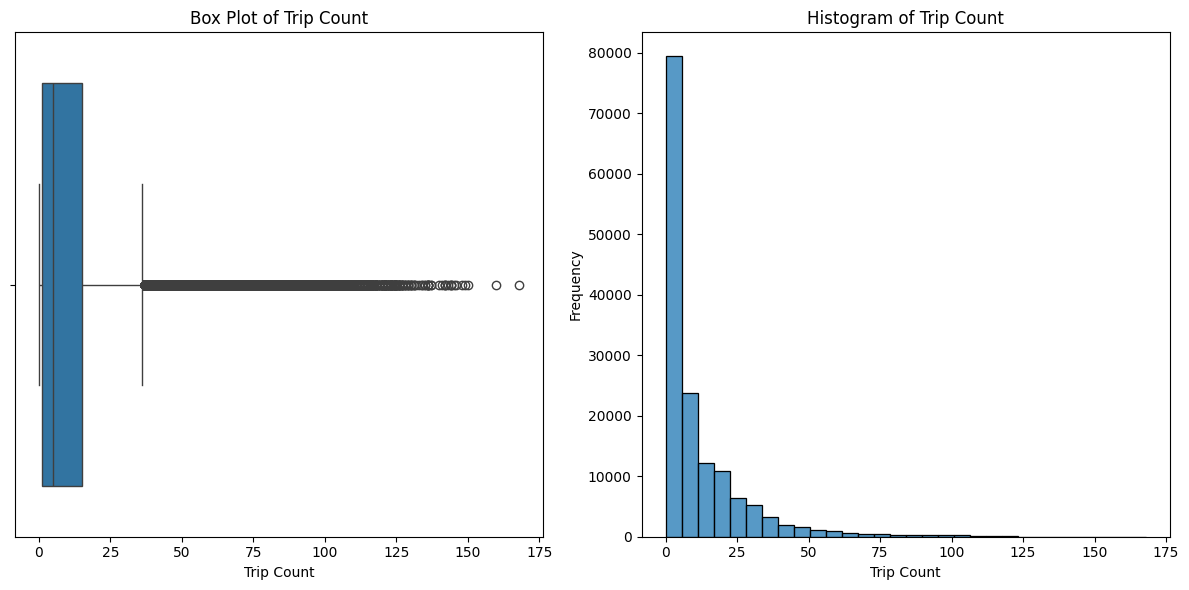

In [6]:
# Check the trip count descriptive statistics
print(df['trip_count'].describe())

# Identify how many 0 values exist in the dataset to assess impact on distribution
zero_trip_count = df[df['trip_count'] == 0].shape[0]
print(f"Number of rows where trip_count is 0: {zero_trip_count}")

# Box Plot for Trip Count
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(x=df['trip_count'])
plt.title('Box Plot of Trip Count')
plt.xlabel('Trip Count')

# Histogram for Trip Count
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['trip_count'], bins=30, kde=False)  
plt.title('Histogram of Trip Count')
plt.xlabel('Trip Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Visualization Review

The histogram reveals a heavily left-skewed distribution of trip count values, which is further supported by the boxplot and descriptive statistics. Given this information, we plan to remove outliers from the dataset. However, to ensure that the range is extended and to preserve a larger sample population, we will calculate the lower and upper bounds for outlier detection after first removing the zero values from the dataset

### Removing Outliers from Trip Count Data Using the IQR Method

In this section, we focus on cleaning the `trip_count` data by removing outliers using the Interquartile Range (IQR) method. We first exclude rows with zero trip counts to ensure a more accurate calculation of the IQR, which helps extend the range and preserve a larger sample population. After calculating the IQR bounds, we remove outliers from the non-zero data and then reintroduce the zero trip count rows to complete the cleaned dataset. Finally, we visualize the distribution of `trip_count` after outlier removal using a histogram.


count    142682.000000
mean          8.366388
std          10.002375
min           0.000000
25%           1.000000
50%           4.000000
75%          13.000000
max          43.000000
Name: trip_count, dtype: float64


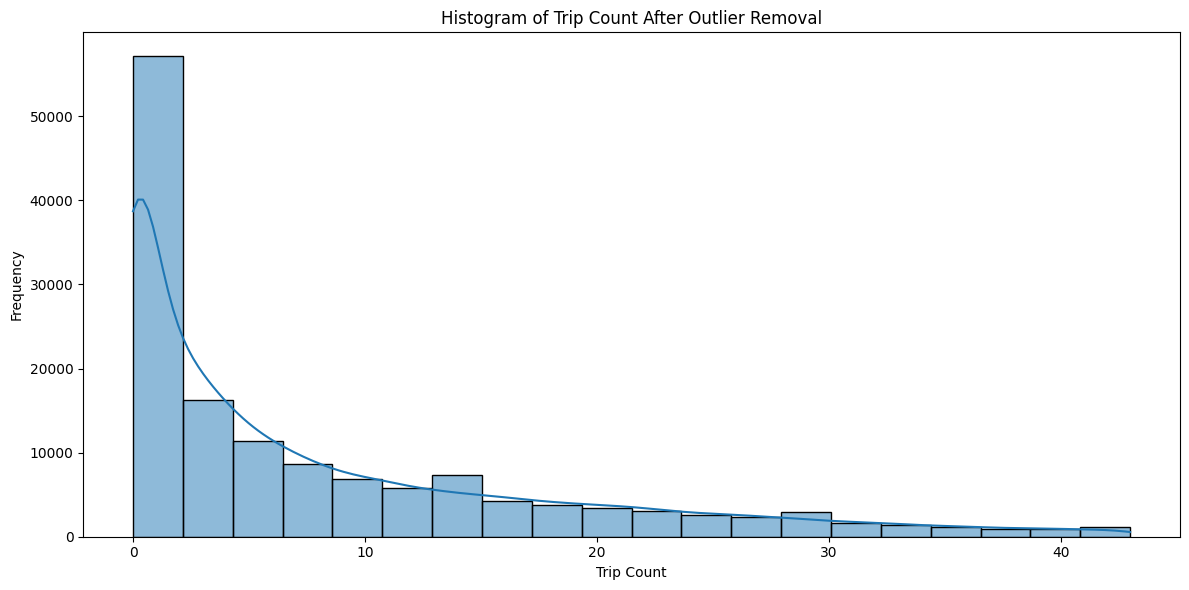

In [7]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove 0 values from the trip_count column
non_zero_df = df[df['trip_count'] != 0]

# Remove outliers for 'trip_count' using IQR method
non_zero_df_reduced = remove_outliers_iqr(non_zero_df, 'trip_count')

# Re-add 0 values to complete dataset
df_cleaned = pd.concat([non_zero_df_reduced, df[df['trip_count'] == 0]])

# Check the cleaned data
print(df_cleaned['trip_count'].describe())

# Histogram for Trip Count
plt.figure(figsize=(12, 6))  # Set the figure size
sns.histplot(df_cleaned['trip_count'], bins= 20, kde=True)
plt.title('Histogram of Trip Count After Outlier Removal')
plt.xlabel('Trip Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Data Modeling

In this section, we develop and evaluate predictive models to forecast bikeshare trip demand. We apply machine learning techniques, such as the Random Forest Regressor, to train the model on historical data. The goal is to identify patterns and relationships that can be used to predict future bike usage, enabling better operational planning and resource allocation.


### Encoding Categorical Features and Reintegrating Original Date and Station ID Columns

This section focuses on preparing the dataset for machine learning by encoding categorical features and preserving essential metadata. We begin by defining the numerical and categorical features for processing, excluding the `date` and `start_station_id` columns temporarily. Using a `ColumnTransformer`, we pass through numerical features and apply one-hot encoding to categorical features, ensuring dense output for easier manipulation. After transforming the data, we reintegrate the original `date` and `start_station_id` columns back into the dataset, preserving their original format for further analysis and modeling. Finally, we verify the data types of the transformed columns to ensure correctness.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define the features for numerical and categorical encoding
numerical_features = ['trip_count', 'prev_dow_trip_count', 'avg_temp_dist', 'precipitation_dist', 'operation_day']
categorical_features = ['start_region_id', 'start_station_id', 'month', 'day_of_week']

# Save the 'date' and 'start_station_id' columns separately
date_station_df = df_cleaned[['date', 'start_station_id']]

# Define the preprocessor without the date and station_id fields
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Pass through numerical features without scaling
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)  # Apply OneHotEncoder with dense output
    ]
)

# Apply the transformations
X_transformed = preprocessor.fit_transform(df_cleaned)
feature_names = preprocessor.get_feature_names_out()

# Create the transformed DataFrame
df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# Merge the 'date' and 'start_station_id' back into the transformed DataFrame
df_transformed = pd.concat([df_transformed, date_station_df.reset_index(drop=True)], axis=1)



### Training and Evaluating a Random Forest Regressor for Trip Count Prediction

In this section, we train a Random Forest Regressor to predict the `trip_count` using the processed dataset. We start by splitting the data into training and testing sets, keeping the `date` and `start_station_id` columns temporarily. Before training, we remove these columns from the feature set to ensure they do not influence the model. After training the Random Forest model, we make predictions on the test set and evaluate the model’s performance using Mean Squared Error (MSE) and R-squared metrics. Finally, we visualize the actual versus predicted trip counts to assess the model's predictive accuracy.


Random Forest Regression - MSE: 18.461233980528206, R-squared: 0.814388382491603


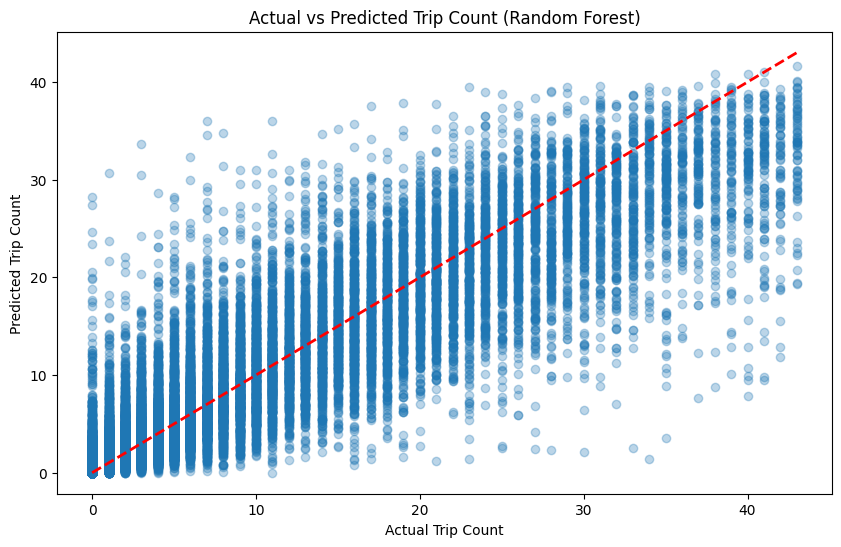

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Split the data including date and station_id
target_variable = 'num__trip_count'
X = df_transformed.drop(columns=[target_variable])  # Keep date and station_id for now
y = df_transformed[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Remove date and station_id before training
X_train_model = X_train.drop(columns=['date', 'start_station_id'])
X_test_model = X_test.drop(columns=['date', 'start_station_id'])

# Train the model
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train_model, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_model)

# Evaluate the model's performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Regression - MSE: {mse_rf}, R-squared: {r2_rf}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Actual vs Predicted Trip Count (Random Forest)')
plt.show()

#### Model Review

The Random Forest Regressor achieved a Mean Squared Error (MSE) of 18.46 and an R-squared value of 0.81 on the test dataset. The relatively low MSE indicates that the model's predictions are close to the actual trip counts on average, while the R-squared value of 0.81 suggests that the model explains approximately 81% of the variance in the trip count data. This indicates a strong overall performance, although there may still be room for improvement in capturing the remaining variability in the dataset.

## Data Analysis and Visualization

In this section, we will visualize the predicted data against actual trip events. We will also explore how these predictions can be applied to real business problems, offering actionable solutions to Operations teams. This analysis aims to bridge the gap between data insights and practical decision-making in bikeshare operations.



### Analyzing and Visualizing Model Performance for the Station with the Highest Lifetime Trips

In this section, we analyze the performance of the Random Forest Regressor specifically for the station with the highest lifetime trip count. We begin by identifying this station based on the total `actual_trip_count` across the dataset. After filtering the data for this station, we sort the records by date and select the first 45 days to focus our analysis. Finally, we visualize the actual versus predicted trip counts for this station over the selected time period.

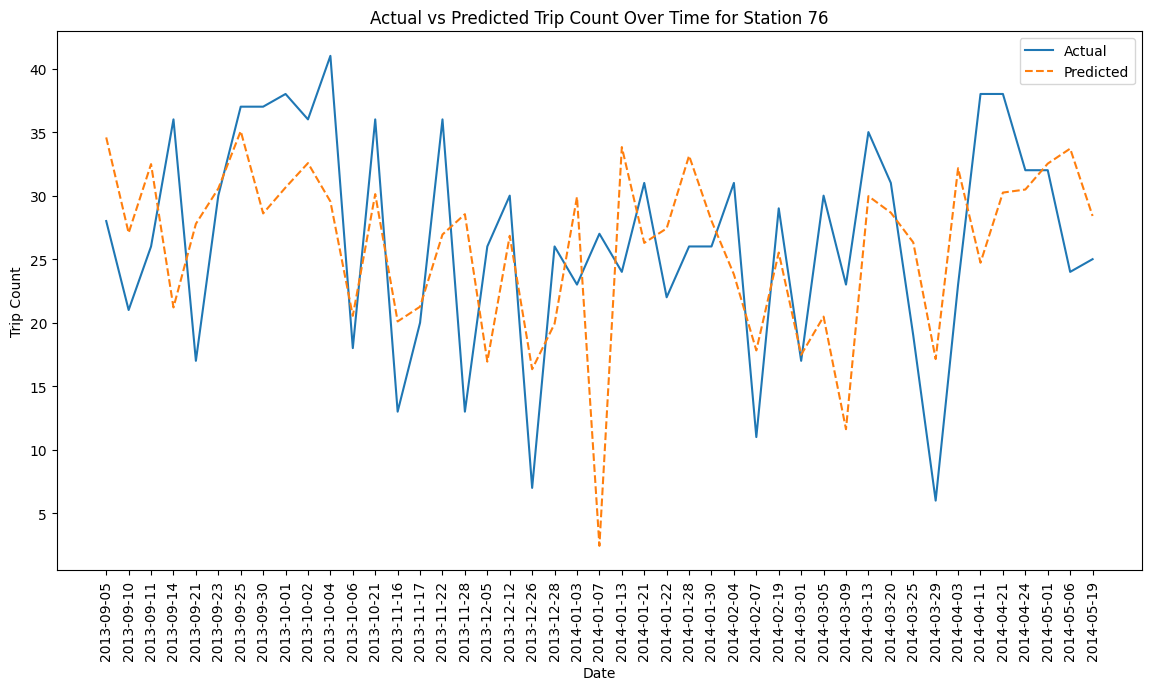

In [36]:
# Re-add date and station_id to the test set for analysis
df_predictions = X_test[['date', 'start_station_id']].copy()
df_predictions['actual_trip_count'] = y_test.values
df_predictions['predicted_trip_count'] = y_pred_rf

# Identify the station with the highest lifetime trips
station_lifetime_trips = df_predictions.groupby('start_station_id')['actual_trip_count'].sum()
highest_trip_station = station_lifetime_trips.idxmax()

# Filter data for the station with the highest lifetime trips
station_df = df_predictions[df_predictions['start_station_id'] == highest_trip_station]

# Sort by date and select the first 45 days
station_df_sorted = station_df.sort_values(by='date').head(45)

# Visualize the actual vs predicted trip counts over the first 45 days
plt.figure(figsize=(14, 7))
plt.plot(station_df_sorted['date'], station_df_sorted['actual_trip_count'], label='Actual')
plt.plot(station_df_sorted['date'], station_df_sorted['predicted_trip_count'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.title(f'Actual vs Predicted Trip Count Over Time for Station {highest_trip_station}')
plt.xticks(rotation = 90) # Rotate x-axis labels 90 degrees
plt.legend()
plt.show()


### Displaying Variance Between Predicted and Actual Values

In this section, we analyze the variance between actual and predicted trip counts to support operational decision-making, particularly in dynamic rebalancing strategies. We begin by calculating the difference between actual and predicted trip counts for each record and generating summary statistics to understand the distribution of these differences. This is followed by a visualization of the distribution through a histogram, allowing us to identify patterns and assess the accuracy of the predictions.

This analysis is crucial for operational decision-makers who need to manage bike fleet distribution effectively. By incorporating the likelihood of variance between predicted and actual demand, they can optimize efforts to rebalance bikes across the network. For instance, our data indicates that maintaining a buffer of approximately 4 bikes over the predicted value will account for 84% of anticipated demand scenarios, ensuring that most stations have enough bikes available for riders on the majority of days. Considering this alongside other fleet metrics—such as population size, the status of active vs. inactive stations, and repair and replacement costs—can significantly inform strategies for bike deployment, hiring, and budgeting at a strategic level.

Summary Statistics for 'Difference' Between Actual and Predicted Trip Counts:
count    28537.000000
mean         0.094994
std          4.295679
min        -30.660000
25%         -1.540000
50%          0.000000
75%          1.460000
max         32.620000
Name: difference, dtype: float64


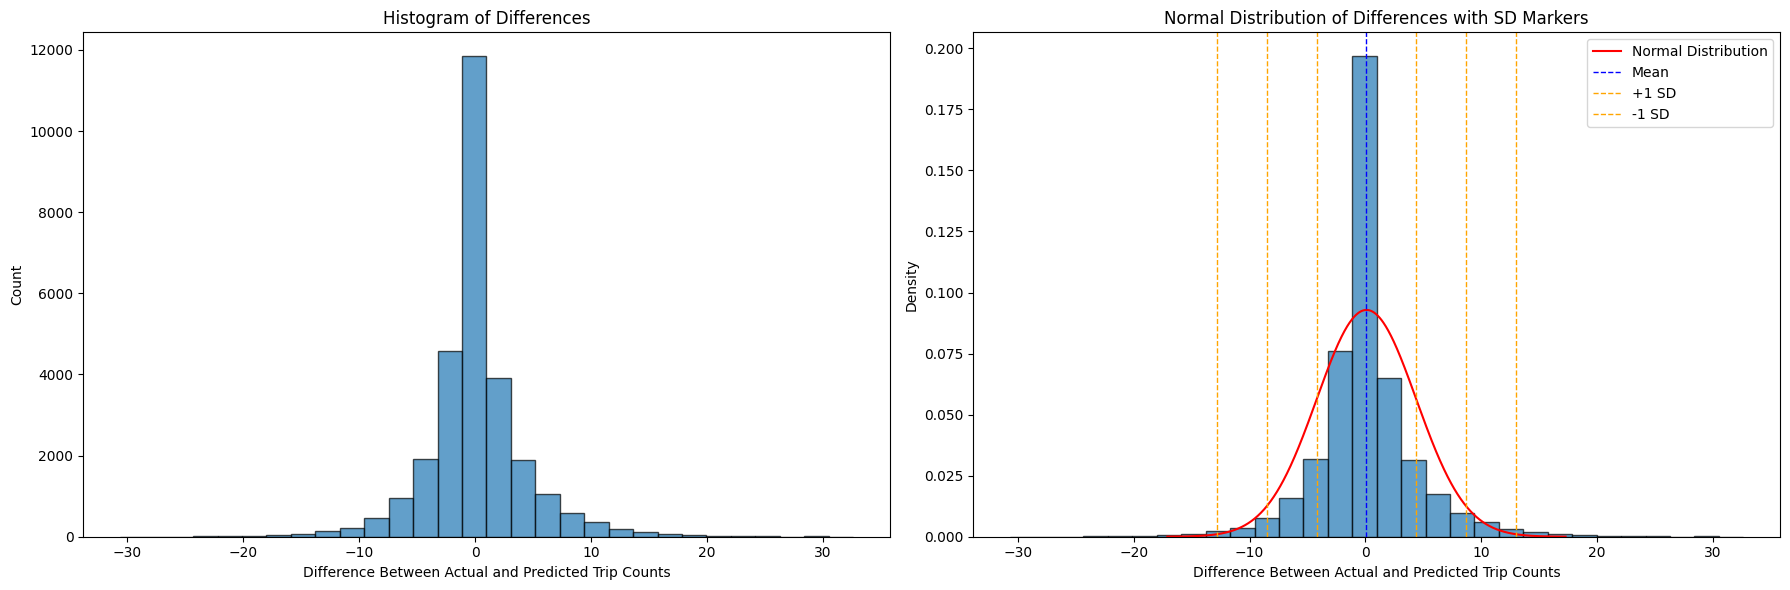

In [44]:
import scipy.stats as stats

# Dynamic Rebalancing Example
actual_vs_predicted = df_predictions.copy()
actual_vs_predicted['difference'] = actual_vs_predicted['actual_trip_count'] - actual_vs_predicted['predicted_trip_count']

# Display summary statistics for the 'difference' column
difference_summary = actual_vs_predicted['difference'].describe()
print("Summary Statistics for 'Difference' Between Actual and Predicted Trip Counts:")
print(difference_summary)

# Calculate the mean and standard deviation of the difference
mean_diff = actual_vs_predicted['difference'].mean()
std_diff = actual_vs_predicted['difference'].std()

# Generate a range of values for plotting the normal distribution curve
x_values = np.linspace(mean_diff - 4*std_diff, mean_diff + 4*std_diff, 1000)
y_values = stats.norm.pdf(x_values, mean_diff, std_diff)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns, set figure size

# Plotting the histogram for 'difference'
ax[0].hist(actual_vs_predicted['difference'], bins=30, edgecolor='k', alpha=0.7)
ax[0].set_xlabel('Difference Between Actual and Predicted Trip Counts')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Differences')

# Plot the bell curve (normal distribution)
ax[1].plot(x_values, y_values, color='red', label='Normal Distribution')
ax[1].hist(actual_vs_predicted['difference'], bins=30, edgecolor='k', alpha=0.7, density=True)
ax[1].axvline(mean_diff, color='blue', linestyle='dashed', linewidth=1, label='Mean')

# Mark the standard deviations
for i in range(1, 4):
    ax[1].axvline(mean_diff + i*std_diff, color='orange', linestyle='dashed', linewidth=1, label=f'+{i} SD' if i == 1 else "")
    ax[1].axvline(mean_diff - i*std_diff, color='orange', linestyle='dashed', linewidth=1, label=f'-{i} SD' if i == 1 else "")

ax[1].set_xlabel('Difference Between Actual and Predicted Trip Counts')
ax[1].set_ylabel('Density')
ax[1].set_title('Normal Distribution of Differences with SD Markers')
ax[1].legend()

plt.tight_layout()
plt.show()


## Conclusion

In this project, we conducted a comprehensive analysis of bikeshare data to predict trip demand and provide actionable insights for operational decision-making. The analysis involved several key steps, including data cleaning, feature engineering, and the use of a Random Forest Regressor to model trip demand. We also explored the impact of various factors such as weather and historical trip data on bike usage.

### Key Takeaways:
- **Predictive Modeling:** The Random Forest model demonstrated strong predictive performance, with an R-squared value of 0.81, indicating that the model can explain 81% of the variance in trip demand. This highlights the model’s effectiveness in forecasting bikeshare usage.
- **Operational Insights:** The analysis provided valuable insights for dynamic rebalancing strategies. By understanding the variance between predicted and actual trip counts, we identified that maintaining a buffer of approximately 4 bikes over the predicted value can account for 84% of anticipated demand, optimizing bike availability. This example is general in nature, and a more comprehensive buffer could be determined and applied at a station level for more granular rebalancing. 
- **Data-Driven Decision-Making:** The findings from this analysis can support data-driven decision-making in fleet management, helping to improve operational efficiency, reduce costs, and enhance user satisfaction.

### Future Work:
- **Model Enhancement:** Future iterations of the model could explore additional features, such as time of day or special events, to further improve prediction accuracy.
- **Scalability:** Incorporating real-time data could provide even more robust insights for bikeshare programs and allow for more reactive redistribution efforts.
- **Operational Implementation:** The insights from this analysis could be integrated into a real-time decision support system to assist in dynamic fleet management and resource allocation.

This project showcases the power of data analysis in optimizing urban mobility solutions. By leveraging predictive modeling and operational insights, bikeshare programs can enhance their service offerings, better meet rider demand, and contribute to more sustainable urban transportation networks.
